# Logistic Regression

## School admittance example data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Issue with `import matplotlib.pyplot as plt` on OSX? See this [stack overflow](https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python) answer.
```
import matplotlib as mpl 
mpl.use('TkAgg')
import matplotlib.pyplot as plt
```

In [2]:
import os
path = os.getcwd() + '/data/ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Text(0, 0.5, 'Exam 2 Score')

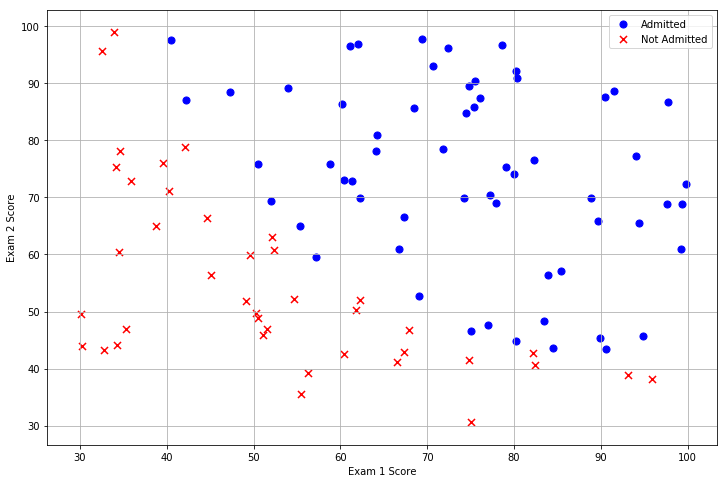

In [3]:
positive = data[data['Admitted'].isin([1])]  
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.grid(True)
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')  
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')  
ax.legend()  
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')  

## Set up the data

In [4]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:, 0:cols-1]
y = data.iloc[:, cols-1:cols]

# convert to numpy arrays and initialize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

In [5]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

## Functions

### Sigmoud

In [6]:
def sigmoid(z):
    """For each given value (typically X * theta.T), calculate the sigmoid value.
    
    :param numpy.ndarray z: Array of values
    :return: An ndarray of sigmoid values
    """
    return 1 / (1 + np.exp(-z))

Test it out

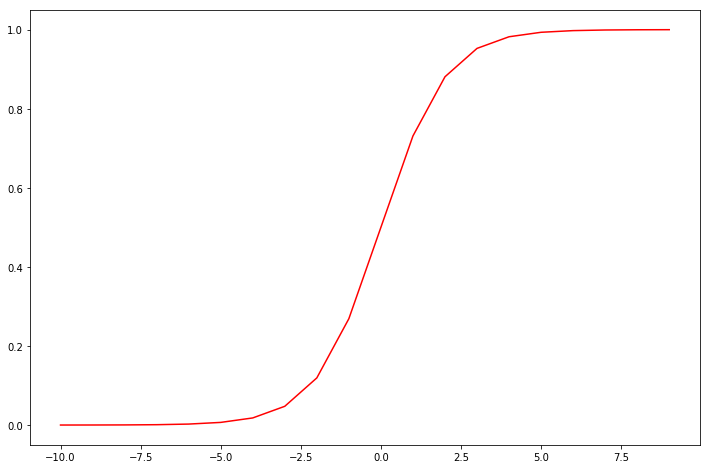

In [8]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')

### Cost

In [9]:
def cost(theta, X, y, learning_rate):
    """Calculate the total cost for every example with a set of parameter values.
    
    :param numpy.ndarray theta: An array of parameter values to use
    :param numpy.ndarray X: An array of examples
    :param numpy.ndarray y: The labeled prediction for each example
    :param int learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :rtype: numpy.float64
    """
    # convert to np matrices for convenience of np's matrix operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = len(X)
    
    # calculate the terms inside the summation
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    
    # skip theta_0, note the 1:theta.shape[1]
    reg = (learning_rate / 2 * m) * np.sum(np.power(theta[:, 1:theta.shape[1]], 2))
    
    # calculate and return the total cost
    return (1/m) * np.sum(first - second) + reg

In [10]:
# for now do not add regularization, use learning rate of 0
cost(theta, X, y, 0)

0.6931471805599453

### Gradient

In [11]:
def gradient(theta, X, y, learning_rate):
    """Calculate a single gradient step.
    
    Only compute a single gradient step so this function can be used with an optimization function.
    
    :param numpy.ndarray theta: An array of parameter values to use
    :param numpy.ndarray X: An array of examples
    :param numpy.ndarray y: The labeled prediction for each example
    :param int learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :return: An ndarray[int] of gradient values
    :rtype: numpy.ndarray
    """
    # convert to np matrices for convenience of np's matrix operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = len(X)

    # find number of parameters and initialize a gradient value for each
    parameters = int(theta.ravel().shape[1])  # shape[1] only exists for matrix, not array
    grad = np.zeros(parameters)
    
    # calculate the error term to use in the gradient function
    # h(x) - y
    error = sigmoid(X * theta.T) - y  # error is an ndarray for each matrix operation
    
    # calculate the gradient value for each parameter using the error value
    # (1/m) * sum(error*x)
    for i in range(parameters):
        term = np.multiply(error, X[:, i])
        
        # skip regularization for theta_0
        if i == 0:
            grad[i] = (1/m) * np.sum(term)  # sum the values for every matrix operation
        else:
            grad[i] = (1/m) * np.sum(term) + ((learning_rate / m) * theta[:, i])
        
    return grad

## Optimize the parameters
scipy has similar optimization functions to Matlab's `fminunc`. `fmin_tnc` wraps a C implementation of the truncated Newton algorithm, and returns the optimized parameters, number of iterations used, and an return code.

In [12]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y, 0))
print("Optimal theta values:", result[0], "in", result[1], "iterations.")

Optimal theta values: [-25.16131858   0.20623159   0.20147149] in 36 iterations.


Calculate the cost with the optimized parameters

In [13]:
# result[0] is an np.ndarray with the optimal theta values
print("Optimal cost", cost(result[0], X, y, 0))

Optimal cost 0.20349770158947475


## Make some predictions

In [14]:
def predict(theta, X):
    """Applies the logistic regression hypothesis to a data set and given parameters.
    
    :param numpy.matrixlib.defmatrix.matrix theta: Matrix of theta values
    :param numpy.ndarray X: Array of examples to predict
    
    :returns: A list of 1s or 0s for each entry in X
    :rtype: list[int]
    """
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

Make a prediction on the training set (X). This value is probably high though, because some data should be held out for a cross validation set.

In [15]:
# Convert theta values to a matrix
theta_min = np.matrix(result[0])

predictions = predict(theta_min, X)  # X is still an ndarray
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0))
           else 0
           for (a, b) in zip(predictions, y)]

# sum(map(int, correct)) is total number of 1s in correct, a vector of 1s and 0s
# modulus this with the length of the vector for the accuracy
accuracy = (sum(map(int, correct)) % len(correct))
print('accuracy: ', accuracy)

accuracy:  89


# Regularization

## Factory test result example data set

In [27]:
path = os.getcwd() + '/data/ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Text(0, 0.5, 'Test 2 Score')

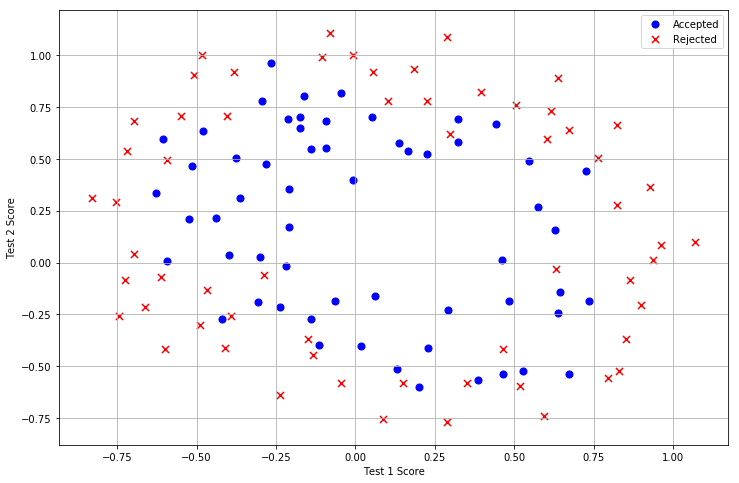

In [28]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

In [29]:
degree = 5
x1 = data2['Test 1']
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

for i in range(1, degree):
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


### Construct features new features
Derive them from polynomials of the original features when there is no linear decision boundary.

## Test the new cost and gradient functions with learning rate added

In [30]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(11)

learningRate = 1

cost(theta2, X2, y2, learningRate)  

0.6931471805599454

### Find new optimal parameters

In [31]:
gradient(theta2, X2, y2, learningRate)

array([0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
       0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
       0.00309594])

todo - I think there is a bug using fmin_tnc here.. these parameters are wrong and do not lead to a better accuracy. Moving on for now

In [36]:
result2 = opt.fmin_tnc(func=cost, x0=theta2, fprime=gradient, args=(X2, y2, learningRate))
result2

(array([ 1.22702520e-04,  7.19894622e-05, -3.74156208e-04, -1.44256440e-04,
         2.93165518e-05, -5.64160710e-05, -1.02826618e-04, -2.83150429e-04,
         6.47304294e-07, -1.99697631e-04, -1.68479611e-05]), 96, 1)

## Make some predictions, now with regularization

In [37]:
theta_min = np.matrix(result2[0])

predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0))
           else 0 
           for (a, b) in zip(predictions, y2)]

accuracy = (sum(map(int, correct)) % len(correct))
print("accuracy", accuracy)

accuracy 77


In [38]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())

/Users/joeselvik/.virtualenvs/machine-learning-coursera/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
model.score(X2, y2)

0.6610169491525424